# Using Articles and Elon Musk Tweets to Predict Tesla Stock 

*by James Lounsbury, December 16, 2020*

## Introduction

The Big data portion of this project was worked on by my team (Gabriel Vigil and Reece Sharp) for CS435. This Report will focus on the Neural Nework I created for modeling the stock market.  

The stock market is increadibly complex system that is very difficult to model. Stocks are constanly fluctuating due to countless unseen variables.For companies that are regularly in the public eye like tesla, public opinion can be a major factor. Because of this to try to improve a network modeling tesla stock we would like to try to account for this. To do this we took many data sets of news articles and filtered for only article titles that include elon or tesla. We also scraped twiter for all elon musk tweets and replies to his tweets. We then prefored sentiment analysis on the articles titles and tweets to determine if they were positive or negitive. Because stock dont only depend on their own factors but also depend on how the overall market is preforming we needed to account for this. This was accomplished by collecting data from the Dow Jones industrial Average. For the Dow Jones we found the difference between the previous days opening price and the current days opening price and this was put for the current day. Finaly for the target value, the difference between the tesla stock current days opening and next days closing was put in the current day. These datasets were then joined on thier datas. 

Because attemping to create a model to predict the exact difference in the stocks seemed to ambitious for our data sets, the tesla difference was broken up into eight catagories. Four catagories were for positive change and four of negitive these being:

In [ ]:
import pandas 
F = {'%': ['>10','5 to 10','1 to 5','0 to 1','0 to -1','-1 to -5','-5 to -10','<-10'],'Classifier': [0,1,2,3,4,5,6,7]}
df=pandas.DataFrame(data=F,index=['','','','','','','',''])
df

,%,Classifier
,>10,0
,5 to 10,1
,1 to 5,2
,0 to 1,3
,0 to -1,4
,-1 to -5,5
,-5 to -10,6
,<-10,7


## Code: used for graphics in Methods and Results; doesnt need to be run 

In [ ]:
import numpy as np
import torch
from torch.autograd import Variable
import time
import pandas
import matplotlib.pyplot as plt

In [ ]:
def Kfold_partition(X, T, n_folds, random_shuffle=True):
    np.random.seed(42)
    rows = np.arange(X.shape[0])
    np.random.shuffle(rows)
    X = X[rows, :]
    T = T[rows, :]
    
    n_samples = X.shape[0]
    n_per_fold = n_samples // n_folds
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)  

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )
    len(folds), len(folds[0]), folds[0][0].shape, folds[0][1].shape
    Xvalidate, Tvalidate = folds[0]
    Xtest, Ttest = folds[1]
    Xtrain, Ttrain = np.vstack([X for (X, _) in folds[2:]]), np.vstack([T for (_, T) in folds[2:]])
    Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape

    return [Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest]

In [ ]:
def confusion_matrix(Y_classes, T):
  class_names=np.unique(T)
  table = []
  for true_class in class_names:
    row = []
    for predicted_class in class_names:
        row.append(100 * np.mean(Y_classes[T == true_class] == predicted_class))
    table.append(row)
    
  print(f'Test percent correct {np.mean(Y_classes == T) * 100:.2f}') 

  return pandas.DataFrame(table, index=class_names, columns=class_names)

In [ ]:
%%writefile optimizers.py
import numpy as np

class Optimizers():

    def __init__(self, all_weights):
        
        self.all_weights = all_weights

        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1
        self.beta2t = 1

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=False, error_convert_f=None):

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=False, error_convert_f=None):

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

if __name__ == '__main__':

    import matplotlib.pyplot as plt
    plt.ion()

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin],
                  n_epochs=500, learning_rate=0.1)

    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin],
                   n_epochs=500, learning_rate=0.1)
    
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

Overwriting optimizers.py


In [ ]:
import optimizers
import sys  

class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views



    def __repr__(self):
        return f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs}, \'{self.activation_function}\')'



    def __str__(self):
        result = self.__repr__()
        if len(self.error_trace) > 0:
            return self.__repr__() + f' trained for {len(self.error_trace)} epochs, final training error {self.error_trace[-1]:.4f}'
    def makeIndicatorVars(self, T):
          if T.ndim == 1:
              T = T.reshape((-1, 1))
          retT = (T == np.unique(T)).astype(int)
          return retT
          
    def softmax (self, X):
        fs = np.exp(X)  
        denom = np.sum(fs, axis=1).reshape((-1, 1))
        gs = fs / (denom + sys.float_info.epsilon)
        return gs

    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        self.verbose=verbose
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        X = (X - self.Xmeans) / self.Xstds
        self.TtrainI = self.makeIndicatorVars(T)
        self.uniqueT=np.unique(T)
        optimizer = optimizers.Optimizers(self.all_weights)


        error_convert_f = lambda nll: (np.exp(-nll))

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, self.TtrainI], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=self.verbose,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, self.TtrainI], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=self.verbose,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        return self

    def relu(self, s):
        s[s < 0] = 0
        return s

    def grad_relu(self, s):
        return (s > 0).astype(int)
    
    def forward_pass(self, X):
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    def error_f(self, X, T):
        temp = self.forward_pass(X)
        Y = self.softmax(temp[-1])
        return - np.mean((T * np.log(Y)))

    def gradient_f(self, X, T):
        Y = self.softmax(self.Ys[-1])
        delta = (Y - T) / (T.shape[0] * T.shape[1])
        n_layers = len(self.n_hiddens_per_layer) + 1
        for layeri in range(n_layers - 1, -1, -1):
              self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
              self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
              if self.activation_function == 'relu':
                  delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
              else:
                  delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        Xtest = ((X - self.Xmeans)/self.Xstds)
        temp = self.forward_pass(Xtest)
        logregOutput = self.softmax(temp[-1])
        predictedTrain = np.argmax(logregOutput,axis=1)
        result = np.array(list(map(lambda x: [self.uniqueT[x].astype(int)] , predictedTrain)))
        return result , logregOutput

**If running code use attached file bellow**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Team_Project_Final_Dataset.csv to Team_Project_Final_Dataset.csv


In [ ]:
FileData = pandas.read_csv('Team_Project_Final_Dataset.csv', delimiter=',',
                          names=('Date', '# of Tweets', '# of +Tweets','# of -Tweets',
                                 '# of +Articles', '# of -Articles', '% Diff Dow Jones',
                                 '% Diff Tesla'))
FileData = FileData.drop([0])
FileData['# of Tweets'] = FileData['# of Tweets'].astype(float)
FileData['# of +Tweets'] = FileData['# of +Tweets'].astype(float)
FileData['# of -Tweets'] = FileData['# of -Tweets'].astype(float)
FileData['# of +Articles'] = FileData['# of +Articles'].astype(float)
FileData['# of -Articles'] = FileData['# of -Articles'].astype(float)
FileData['% Diff Dow Jones'] = FileData['% Diff Dow Jones'].astype(float)
FileData['% Diff Tesla'] = FileData['% Diff Tesla'].astype(int)
FileData

,Date,# of Tweets,# of +Tweets,# of -Tweets,# of +Articles,# of -Articles,% Diff Dow Jones,% Diff Tesla
1,2018-09-27,NaN,NaN,NaN,NaN,NaN,-0.003653,7
2,2013-06-28,109.0,99.0,83.0,NaN,NaN,0.000000,1
3,2013-06-29,NaN,NaN,NaN,NaN,NaN,-0.002772,1
4,2013-06-30,23.0,20.0,13.0,NaN,NaN,-0.002772,1
5,2013-07-15,525.0,791.0,620.0,NaN,NaN,0.001524,7
...,...,...,...,...,...,...,...,...
4199,2011-10-14,NaN,NaN,NaN,NaN,NaN,0.010974,5
4200,2011-10-15,NaN,NaN,NaN,NaN,NaN,-0.007141,5
4201,2011-10-16,NaN,NaN,NaN,NaN,NaN,-0.007141,5
4202,2012-03-22,3.0,3.0,4.0,NaN,NaN,-0.009464,5


In [ ]:
AllCat=[FileData.dropna()]
AllCat.append(FileData.drop(['% Diff Dow Jones'],axis=1).dropna())
AllCat.append(FileData.drop(['# of -Tweets','# of -Articles'],axis=1).dropna())
AllCat.append(FileData.drop(['# of -Tweets','# of -Articles'],axis=1).dropna())
TwoCat=[]
for i in AllCat:
  TwoCat.append(i.replace({'% Diff Tesla': {1: 0,2: 0,3: 0,5: 4,6: 4,7: 4}}).replace({'% Diff Tesla': {4:1}}))
AllCat[0]

,Date,# of Tweets,# of +Tweets,# of -Tweets,# of +Articles,# of -Articles,% Diff Dow Jones,% Diff Tesla
25,2016-07-21,361.0,527.0,376.0,3.0,2.0,-0.003523,5
26,2016-07-21,1183.0,1172.0,1024.0,3.0,2.0,-0.003523,5
37,2017-05-13,1354.0,1999.0,1192.0,1.0,1.0,0.004248,5
38,2017-05-13,541.0,170.0,124.0,1.0,1.0,0.004248,5
112,2017-04-07,750.0,361.0,197.0,1.0,0.0,0.000000,1
...,...,...,...,...,...,...,...,...
4187,2016-03-31,647.0,657.0,487.0,0.0,5.0,0.001854,2
4188,2016-03-31,173.0,293.0,220.0,0.0,5.0,0.001854,2
4189,2016-03-31,615.0,543.0,546.0,0.0,5.0,0.001854,2
4190,2016-03-31,243.0,185.0,172.0,0.0,5.0,0.001854,2


In [ ]:
AllCatX_T=[]
for i in AllCat:
  AllCatX_T.append(Kfold_partition(i.iloc[:,1:-1].to_numpy(), i.iloc[:,-1:].to_numpy(), 10, random_shuffle=True))
TwoCatX_T=[]
for i in TwoCat:
  TwoCatX_T.append(Kfold_partition(i.iloc[:,1:-1].to_numpy(), i.iloc[:,-1:].to_numpy(), 10, random_shuffle=True))

In [ ]:
AllCatNnets=[]
TwoCatNnets=[]
for i in range(4):
  AllCatNnets.append([])
  TwoCatNnets.append([])
  for j in [[10],[100],[10,20,10],[10,100],[100,10],[100,10,100],[100,200,100],[10,100,10],[20,50,100,50,20]]:
    AllCatNnets[i].append(NeuralNetwork(AllCatX_T[i][0].shape[1], j, len(np.unique(AllCatX_T[i][1]))))
    TwoCatNnets[i].append(NeuralNetwork(TwoCatX_T[i][0].shape[1], j, 2))

In [ ]:
for i in range(4):
  for nnet in AllCatNnets[i]:
    nnet.train(AllCatX_T[i][0], AllCatX_T[i][1], 5000, .0005, method='adam', verbose=False)
    print(nnet)
for i in range(4):
  for nnet in TwoCatNnets[i]:
    nnet.train(TwoCatX_T[i][0], TwoCatX_T[i][1], 5000, .0005, method='adam', verbose=False)
    print(nnet)

NeuralNetwork(6, [10], 7, 'tanh') trained for 5000 epochs, final training error 0.8569
NeuralNetwork(6, [100], 7, 'tanh') trained for 5000 epochs, final training error 0.9534
NeuralNetwork(6, [10, 20, 10], 7, 'tanh') trained for 5000 epochs, final training error 0.8733
NeuralNetwork(6, [10, 100], 7, 'tanh') trained for 5000 epochs, final training error 0.9910
NeuralNetwork(6, [100, 10], 7, 'tanh') trained for 5000 epochs, final training error 0.8726
NeuralNetwork(6, [100, 10, 100], 7, 'tanh') trained for 5000 epochs, final training error 0.9875
NeuralNetwork(6, [100, 200, 100], 7, 'tanh') trained for 5000 epochs, final training error 0.9998
NeuralNetwork(6, [10, 100, 10], 7, 'tanh') trained for 5000 epochs, final training error 0.8575
NeuralNetwork(6, [20, 50, 100, 50, 20], 7, 'tanh') trained for 5000 epochs, final training error 0.9764
NeuralNetwork(5, [10], 7, 'tanh') trained for 5000 epochs, final training error 0.8280
NeuralNetwork(5, [100], 7, 'tanh') trained for 5000 epochs, fina

In [ ]:
def numberCorrect(nnet,X,T):
  Y_classes, probs = nnet.use(X)
  return np.sum(T==Y_classes)

def bestNet(nnets,Xtest,Ttest,Xval,Tval):
  bestaverage=0
  bestIndex=0
  for i in range(len(nnets)):
    curAvg=(numberCorrect(nnets[i],Xtest,Ttest)+numberCorrect(nnets[i],Xval,Tval))/(len(Ttest)+len(Tval))
    if bestaverage<curAvg:
      bestaverage=curAvg
      bestIndex=i
  return bestIndex

In [ ]:
bestAllNets=[]
for i in range(4):
  index=bestNet(AllCatNnets[i],AllCatX_T[i][2],AllCatX_T[i][3],AllCatX_T[i][4],AllCatX_T[i][5])
  bestAllNets.append(AllCatNnets[i][index])
bestTwoNets=[]
for i in range(4):
  index=bestNet(TwoCatNnets[i],TwoCatX_T[i][2],TwoCatX_T[i][3],TwoCatX_T[i][4],TwoCatX_T[i][5])
  bestTwoNets.append(TwoCatNnets[i][index])

In [ ]:
for i in range(4):
  print(i)
  print("--------------------------------------------------")
  print("All Catagories")
  print(bestAllNets[i])
  Yclasses, probs=bestAllNets[i].use(AllCatX_T[i][2])
  print("Test")
  print(confusion_matrix(Yclasses,AllCatX_T[i][3]))
  print()
  print("Validate")
  Yclasses, probs=bestAllNets[i].use(AllCatX_T[i][4])
  print(confusion_matrix(Yclasses,AllCatX_T[i][5]))
  print()
  print("Two Catagories")
  print(bestTwoNets[i])
  Yclasses, probs=bestTwoNets[i].use(TwoCatX_T[i][2])
  print("Test")
  print(confusion_matrix(Yclasses,TwoCatX_T[i][3]))
  print()
  print("Validate")
  Yclasses, probs=bestTwoNets[i].use(TwoCatX_T[i][4])
  print(confusion_matrix(Yclasses,TwoCatX_T[i][5]))
  print("--------------------------------------------------")

0
--------------------------------------------------
All Catagories
NeuralNetwork(6, [10, 100], 7, 'tanh') trained for 5000 epochs, final training error 0.9910
Test
Test percent correct 50.00
      1          2           3          4          5    6
1  50.0   0.000000    0.000000   0.000000  50.000000  0.0
2   0.0  42.857143   14.285714  14.285714  28.571429  0.0
3   0.0   0.000000   60.000000   0.000000  40.000000  0.0
4   0.0   0.000000   20.000000  40.000000  40.000000  0.0
5   0.0  16.666667    0.000000   0.000000  66.666667  0.0
6   0.0   0.000000  100.000000   0.000000   0.000000  0.0

Validate
Test percent correct 50.00
           2          3     4          5         6
2  60.000000   0.000000  20.0  20.000000  0.000000
3   0.000000  60.000000   0.0  40.000000  0.000000
4  25.000000   0.000000  50.0  25.000000  0.000000
5  18.181818   9.090909   0.0  54.545455  9.090909
6   0.000000  33.333333   0.0  66.666667  0.000000

Two Catagories
NeuralNetwork(6, [10, 20, 10], 2, 'tanh') t

## Methods

Since I decided to break up the tesla stock data into catagories the only correct model to use was a classification Neural network. For this i reused the classification network from Hw Four. For the optimizer i use the Adam implimentaion from the same homework. To ensure the data was broken up into a random sets for training and testing I used K-fold partioning. 

To test if our the theory about public opinion being a useful feature to use in the modeling of stock data; i trained multiple network structures with and without some features. The sets of features i train were, the entire feature list, the feature list excluding the dow jones, the feature list excluding the negitive sentiment analysis, and the feature set excluding the positve sentiment analyis. For ensuring that all feature sets had a decient chance to create a accurate model, I trained a set of multiple networks for each feature set. 

This set being 

 [ [10],
 [100],
 [10,20,10],
 [10,100],
 [100,10],
 [100,10,100],
 [100,200,100],
 [10,100,10],
 [20,50,100,50,20],
 [10,50,100,200,100,50,10],
 [200,100,50,10,50,100,200] ]

These were all train for 5000 epochs with a learning rate of .0005 because in inital trials this gave the most accurate values on average. Once all the networks were trained I ran each set through a function to find the best network for that set. This was done by summing the number of correct classifications for both the test and validate data set and dividing by the sum of their sizes. The network with the highest value was then conisdered the best.

After running this a problem became clear with our data set. For the catagory system that we choose the distribution was no where neer evenly distributed.

 

Text(0, 0.5, 'Catagory')

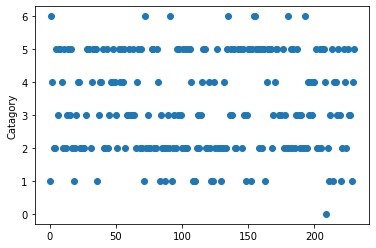

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(range(AllCatX_T[0][1].size),AllCatX_T[0][1])
plt.ylabel('Catagory')

As the plot above shows our data set is focused in the 2 and 5 catagories with little to no points in the 0-1 and 6-7 ranges. This was heavily reflected in our models, with the all the neworks only guessing between the range of 2-5.
To solve this without having to rerun the join on the inital data set, I decided to do a mapping of the original catagories to a new set. The New set contained only two catagories, 0 for positive price change and 1 for negitive price change. This was simply done by mapping all catagories < 4 to 0 and 4 <= catagories to 1. 

Catagory 1 size = 105, Catagory 0 size = 126


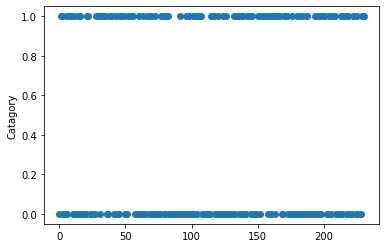

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(range(TwoCatX_T[0][1].size),TwoCatX_T[0][1])
plt.ylabel('Catagory')
print("Catagory 1 size = "+str(np.sum(TwoCatX_T[0][1]==1))+", Catagory 0 size = "+str(np.sum(TwoCatX_T[0][1]==0)))

With this new Catagory System, the distrabution is evenly split between the two catagories allowing for a better model to be trained. Once I had the new intial data set the same procceses that were preformed on the 8 catagory were done to the 2. 

## Results

### Full Feature Set

In [ ]:
  i=0
  print("--------------------------------------------------")
  print("All Catagories")
  print(bestAllNets[i])
  Yclasses, probs=bestAllNets[i].use(AllCatX_T[i][2])
  print("Test")
  print(confusion_matrix(Yclasses,AllCatX_T[i][3]))
  print()
  print("Validate")
  Yclasses, probs=bestAllNets[i].use(AllCatX_T[i][4])
  print(confusion_matrix(Yclasses,AllCatX_T[i][5]))
  print("--------------------------------------------------")
  print("Two Catagories")
  print(bestTwoNets[i])
  Yclasses, probs=bestTwoNets[i].use(TwoCatX_T[i][2])
  print("Test")
  print(confusion_matrix(Yclasses,TwoCatX_T[i][3]))
  print()
  print("Validate")
  Yclasses, probs=bestTwoNets[i].use(TwoCatX_T[i][4])
  print(confusion_matrix(Yclasses,TwoCatX_T[i][5]))
  print("--------------------------------------------------")

--------------------------------------------------
All Catagories
NeuralNetwork(6, [10, 100], 7, 'tanh') trained for 5000 epochs, final training error 0.9910
Test
Test percent correct 50.00
      1          2           3          4          5    6
1  50.0   0.000000    0.000000   0.000000  50.000000  0.0
2   0.0  42.857143   14.285714  14.285714  28.571429  0.0
3   0.0   0.000000   60.000000   0.000000  40.000000  0.0
4   0.0   0.000000   20.000000  40.000000  40.000000  0.0
5   0.0  16.666667    0.000000   0.000000  66.666667  0.0
6   0.0   0.000000  100.000000   0.000000   0.000000  0.0

Validate
Test percent correct 50.00
           2          3     4          5         6
2  60.000000   0.000000  20.0  20.000000  0.000000
3   0.000000  60.000000   0.0  40.000000  0.000000
4  25.000000   0.000000  50.0  25.000000  0.000000
5  18.181818   9.090909   0.0  54.545455  9.090909
6   0.000000  33.333333   0.0  66.666667  0.000000
--------------------------------------------------
Two Catago

With the entire feature set, we are getting quite high accuracies for both the 2 and 8 catagory. For 8 catagory we can see that for this model the network mostly guesses the 5th catagory which is to be expected with our data set being skewed. For the extreams(0-1,6-7) the model is almost never correct which is also to be expected with our data. The 2 catagory model has extrmely high accuracy for the scope of the problem, but from all of my runs never breaks 80%. This could be do to many factors, i belive this is mainly caused by two factors. Firstly because of the 0% spliting point for the catagories there is no highly defined edges for the catagories. Because of this I could see a 1% increase could easily be confused with a decrease vice versa. Secondly I think that we are not taking acount of many more factors that effect the stock like how the stock change priviously can effect how it will change.

### No Dow Jones

In [ ]:
  i=1
  print("--------------------------------------------------")
  print("All Catagories")
  print(bestAllNets[i])
  Yclasses, probs=bestAllNets[i].use(AllCatX_T[i][2])
  print("Test")
  print(confusion_matrix(Yclasses,AllCatX_T[i][3]))
  print()
  print("Validate")
  Yclasses, probs=bestAllNets[i].use(AllCatX_T[i][4])
  print(confusion_matrix(Yclasses,AllCatX_T[i][5]))
  print("--------------------------------------------------")
  print("Two Catagories")
  print(bestTwoNets[i])
  Yclasses, probs=bestTwoNets[i].use(TwoCatX_T[i][2])
  print("Test")
  print(confusion_matrix(Yclasses,TwoCatX_T[i][3]))
  print()
  print("Validate")
  Yclasses, probs=bestTwoNets[i].use(TwoCatX_T[i][4])
  print(confusion_matrix(Yclasses,TwoCatX_T[i][5]))
  print("--------------------------------------------------")

--------------------------------------------------
All Catagories
NeuralNetwork(5, [20, 50, 100, 50, 20], 7, 'tanh') trained for 5000 epochs, final training error 0.8095
Test
Test percent correct 41.38
     1           2          3    4           5    6
1  0.0  100.000000   0.000000  0.0    0.000000  0.0
2  0.0   85.714286   0.000000  0.0   14.285714  0.0
3  0.0    0.000000  20.000000  0.0   80.000000  0.0
4  0.0   33.333333  16.666667  0.0   50.000000  0.0
5  0.0   37.500000   0.000000  0.0   62.500000  0.0
6  0.0    0.000000   0.000000  0.0  100.000000  0.0

Validate
Test percent correct 41.38
     1          2     3    4           5    6
1  0.0   0.000000   0.0  0.0  100.000000  0.0
2  0.0  50.000000   0.0  0.0   50.000000  0.0
3  0.0  25.000000  25.0  0.0   50.000000  0.0
4  0.0  66.666667   0.0  0.0   33.333333  0.0
5  0.0  42.857143   0.0  0.0   57.142857  0.0
6  0.0   0.000000   0.0  0.0  100.000000  0.0
--------------------------------------------------
Two Catagories
NeuralNet

Once the Dow Jones data was removed we can see a clear drop in the accuracy of our models. The 8 catagory network changed to only guess 2 or 5 and at about a 50/50 split between the 2, to me this shows that its just guessing between the two high most common points in our data. For the 2 catagory its also 50/50, from this we can see that using the Dow jones was a highly influential feature and did help us represent how the overall market preformed. 

### Only Positive or Negitive 

In [ ]:
  i=2
  print('|Only Positive|')
  print("--------------------------------------------------")
  print("All Catagories")
  print(bestAllNets[i])
  Yclasses, probs=bestAllNets[i].use(AllCatX_T[i][2])
  print("Test")
  print(confusion_matrix(Yclasses,AllCatX_T[i][3]))
  print()
  print("Validate")
  Yclasses, probs=bestAllNets[i].use(AllCatX_T[i][4])
  print(confusion_matrix(Yclasses,AllCatX_T[i][5]))
  print("--------------------------------------------------")
  print("Two Catagories")
  print(bestTwoNets[i])
  Yclasses, probs=bestTwoNets[i].use(TwoCatX_T[i][2])
  print("Test")
  print(confusion_matrix(Yclasses,TwoCatX_T[i][3]))
  print()
  print("Validate")
  Yclasses, probs=bestTwoNets[i].use(TwoCatX_T[i][4])
  print(confusion_matrix(Yclasses,TwoCatX_T[i][5]))
  print("--------------------------------------------------")
  i=3
  print('|Only Negitive|')
  print("--------------------------------------------------")
  print("All Catagories")
  print(bestAllNets[i])
  Yclasses, probs=bestAllNets[i].use(AllCatX_T[i][2])
  print("Test")
  print(confusion_matrix(Yclasses,AllCatX_T[i][3]))
  print()
  print("Validate")
  Yclasses, probs=bestAllNets[i].use(AllCatX_T[i][4])
  print(confusion_matrix(Yclasses,AllCatX_T[i][5]))
  print("--------------------------------------------------")
  print("Two Catagories")
  print(bestTwoNets[i])
  Yclasses, probs=bestTwoNets[i].use(TwoCatX_T[i][2])
  print("Test")
  print(confusion_matrix(Yclasses,TwoCatX_T[i][3]))
  print()
  print("Validate")
  Yclasses, probs=bestTwoNets[i].use(TwoCatX_T[i][4])
  print(confusion_matrix(Yclasses,TwoCatX_T[i][5]))
  print("--------------------------------------------------")

|Only Positive|
--------------------------------------------------
All Catagories
NeuralNetwork(4, [100, 10], 7, 'tanh') trained for 5000 epochs, final training error 0.8720
Test
Test percent correct 42.86
      1          2          3           4          5    6
1  50.0   0.000000   0.000000   25.000000  25.000000  0.0
2   0.0  42.857143   0.000000   14.285714  42.857143  0.0
3   0.0  40.000000  40.000000   20.000000   0.000000  0.0
4   0.0   0.000000  20.000000   40.000000  40.000000  0.0
5   0.0   0.000000  16.666667   16.666667  50.000000  0.0
6   0.0   0.000000   0.000000  100.000000   0.000000  0.0

Validate
Test percent correct 42.86
           2          3          4          5    6
2  40.000000  60.000000   0.000000   0.000000  0.0
3   0.000000  40.000000  40.000000  20.000000  0.0
4  25.000000   0.000000  75.000000   0.000000  0.0
5   9.090909   9.090909  36.363636  45.454545  0.0
6   0.000000   0.000000  33.333333  66.666667  0.0
---------------------------------------------

In comparing both feature sets to the origonal set we can see some small differences. For the only positive feature set it close in accuarcy to the origonal data set, but interestingly it is slightly more accurate in picking the the negitive change. For the only negitive only set is less accurate than the both positive only and the origonal feature sets on average, but clearly adds value in some cases. This is shown by the Test accuracy being higher than in the positive only.

## Conclusions

From my result it is clear that using sentment analysis infomation on articles and tweets do help improve models made on tesla stock. This is due to the fact that they can help give a metric on public opinion to the model. It is also clear from the NO Dow Jones models that this public opinon information is far from enough to adiquitly model the stocks alone, but is more of a useful addition. From the results of the only positive or negitive model we can see that the positive data is slightly more useful in modeling; but by using both you are able to get a more accurate and more general model.

To improve this model there are many steps that could be taken.A major improvement would be, a more complete data set to train on. This data set was trimed down to less than a 20th of the origonal data, due to missing values.   Another area of improvement would be a more comprehensive feature list. By adding information on the stocks previous states we could more accuratly predict the future stock, because of the stocks chaotic nature. And finaly a major enhancement would be a more optimal selection of catagorys. This helps the network make clearer distinctions between each catagory when traning.    

### References

[1]Apache, “apache/hadoop.” [Online]. Available: https://github.com/apache/hadoop.

[2]D. P. Kingma and J. Ba, “Adam: A Method for Stochastic Optimization,” CoRR, 2015.

[3]JohnSnowLabs, “JohnSnowLabs/spark-nlp,” GitHub. [Online]. Available: https://github.com/JohnSnowLabs/spark-nlp.

[4]Matplotlib, “matplotlib/matplotlib,” GitHub. [Online]. Available: https://github.com/matplotlib/matplotlib.

[5]Pytorch, “pytorch/pytorch,” GitHub. [Online]. Available: https://github.com/pytorch/pytorch.

[6]"twintproject/twint", GitHub, 2020. [Online]. Available: https://github.com/twintproject/twint. [Accessed: 03- Dec- 2020].

[7]"NumPy", Numpy.org, 2020. [Online]. Available: https://numpy.org/. [Accessed: 03- Dec- 2020].

[8]"Apache Spark™ - Unified Analytics Engine for Big Data", Spark.apache.org, 2020. [Online]. Available: https://spark.apache.org/. [Accessed: 03- Dec- 2020].


Your report for a single person team should contain approximately 2,000 words times number of team members, in markdown cells.  You can count words by running the following python code in your report directory.  Projects with two people, for example, should contain 4,000 to 8,000 words.

## Datasets

https://www.kaggle.com/timoboz/tesla-stock-data-from-2010-to-2020
	Contains all tesla opening and closing stock prices from 2010 to 2020 by day.

https://www.kaggle.com/snapcrack/all-the-news?select=articles1.csv
	Data set of 1.2gb of news articles from multiple publications between 2015-2017.

https://www.kaggle.com/rootuser/worldnews-on-reddit?select=reddit_worldnews_start_to_2016-11-22.csv
Data set of WorldNews on Reddit from 2008 to 2016

https://www.kaggle.com/rmisra/news-category-dataset
Data set of HuffPost articles from 2012 to 2018. 

https://www.kaggle.com/aaron7sun/stocknews
Data set of Reddit new ranked by user upvotes and a data set of the Dow Jones Industrial Average from 2008 to 2016.

https://drive.google.com/drive/folders/1ZS9fMyR4vruguWFcq_B6mwzp_dtttn24?usp=sharing
Dataset containing every tweet from 2011/1/1 - 2020/12/1 that contains either “tesla” or “@elonmusk”
	
https://finance.yahoo.com/quote/%5EDJI/history?period1=1262476800&period2=1606953600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=false.
Dataset of historical stock values of Dow Jones Industrial Average (DJI) through the dates:Jan 02, 2010 - Dec 02, 2020


In [ ]:
import io
from nbformat import current
import glob
nbfile = glob.glob('Project Report Example.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

IndexError: ignored